In [2]:
!pip install arrow

In [3]:
!pip install pygam

In [22]:
import numpy as np
import pandas as pd
import arrow
import pygam
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [5]:
nhanes = pd.read_feather("nhanes.feather")

In [6]:
nhanes

,SEQN,LBXTC,LBDTCSI,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,...,SLQ040,SLQ120,SLQ320,SLQ330,SLD013,WTSAF2YR,LBXGLU,LBDGLUSI,PHAFSTHR,PHAFSTMN
0,73557.0,167.0,4.32,8,Both interviewed and MEC examined,Male,69,None,Non-Hispanic Black,Non-Hispanic Black,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
1,73558.0,170.0,4.40,8,Both interviewed and MEC examined,Male,54,None,Non-Hispanic White,Non-Hispanic White,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
2,73559.0,126.0,3.26,8,Both interviewed and MEC examined,Male,72,None,Non-Hispanic White,Non-Hispanic White,...,None,None,None,None,None,142196.890197,193.0,10.713,15.0,51.0
3,73560.0,168.0,4.34,8,Both interviewed and MEC examined,Male,9,None,Non-Hispanic White,Non-Hispanic White,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
4,73561.0,201.0,5.20,8,Both interviewed and MEC examined,Female,73,None,Non-Hispanic White,Non-Hispanic White,...,None,None,None,None,None,142266.006548,107.0,5.940,14.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,83726.0,NaN,NaN,8,Both interviewed and MEC examined,Male,40,None,Mexican American,Mexican American,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
8287,83727.0,190.0,4.91,8,Both interviewed and MEC examined,Male,26,None,Other Hispanic,Other Hispanic,...,None,None,None,None,None,67775.162806,108.0,5.995,14.0,30.0
8288,83729.0,152.0,3.93,8,Both interviewed and MEC examined,Female,42,None,Non-Hispanic Black,Non-Hispanic Black,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
8289,83730.0,167.0,4.32,8,Both interviewed and MEC examined,Male,7,None,Other Hispanic,Other Hispanic,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN


In [7]:
from pygam import LinearGAM, s, f, te, l
from pygam import GAM

In [8]:
nhanes['BPX'] = (nhanes['BPXSY1'] + nhanes['BPXDI1'])/2

In [9]:
nhanes['Smoke'] = nhanes['SMQ020'].apply(lambda x:10 if x == 1 else 0)

In [10]:
nhanes['Physical'] = pd.qcut(nhanes['PAD680'], 100, labels = False, duplicates='drop')

In [11]:
nhanes['Diet'] = (
    pd.qcut(nhanes['DR1TSODI'], 100, labels=False) +
    pd.qcut(nhanes['DR1TSFAT'], 100, labels=False) +
    pd.qcut(nhanes['DR1TCHOL'], 100, labels=False) +
    pd.qcut(nhanes['DR1TSUGR'], 100, labels=False)
) / 4

In [12]:
nhanes['Alcohol'] = pd.qcut(nhanes['ALQ130'], 100, labels = False, duplicates='drop')

In [13]:
filtered_data = nhanes.dropna(subset=['RIDAGEYR', 'LBXTC', 'RIAGENDR', 'RIDRETH3', 'BMXBMI', 'LBXGLU', 'SLD010H', 'BPX', 'Smoke', 'Physical', 'Diet', 'Alcohol'])

In [14]:
ldl = filtered_data['LBXTC'].values
ldl

array([168., 168., 182., ..., 121., 165., 190.])

In [15]:
# Create a dictionary to map categories to numerical values
category_mapping = {'Male': 0, 'Female': 1}

# Use the map function to transform the categories to numerical values
RIAGENDR_encoded = [category_mapping[gender] for gender in filtered_data['RIAGENDR']]

In [16]:
# Create a dictionary to map categories to numerical values
category_mapping = {'Mexican American': 0, 'Other Hispanic': 1, 'Non-Hispanic White': 2, 'Non-Hispanic Black': 3, 'Non-Hispanic Asian': 4, 'Other Race - Including Multi-Racial': 5 }
# Use the map function to transform the categories to numerical values
RIDRETH3_encoded = [category_mapping[race] for race in filtered_data['RIDRETH3']]

In [17]:
X = filtered_data[['RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'BMXBMI', 'LBXGLU', 'SLD010H', 'BPX', 'Smoke', 'Physical', 'Diet', 'Alcohol']].values

In [18]:
new_var = ['RIDAGEYR', 'BMXBMI', 'LBXGLU', 'SLD010H', 'BPX', 'Smoke', 'Physical', 'Diet', 'Alcohol']
X = np.column_stack((RIAGENDR_encoded, RIDRETH3_encoded, filtered_data[new_var].values))

In [27]:
gam = LinearGAM(f(0) + f(1) + s(2) + l(3) + l(4) + l(5) + l(6) + l(7) + l(8) + l(9) + l(10))
gam_X = gam.fit(X, ldl)

In [21]:
lams = np.random.rand(100, 11) # random points on [0, 1], with shape (100, 11)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 1e3
gam.gridsearch(X, ldl, lam=lams)
gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.5298
Link Function:                     IdentityLink Log Likelihood:                                -12045.9132
Number of Samples:                         1478 AIC:                                            24126.8861
                                                AICc:                                           24127.3312
                                                GCV:                                             1409.7444
                                                Scale:                                           1381.3934
                                                Pseudo R-Squared:                                   0.1301
Feature Function                  Lam

<ipython-input-21-3d0b3b5117c5>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [25]:
gam_X.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.5298
Link Function:                     IdentityLink Log Likelihood:                                -12045.9132
Number of Samples:                         1478 AIC:                                            24126.8861
                                                AICc:                                           24127.3312
                                                GCV:                                             1409.7444
                                                Scale:                                           1381.3934
                                                Pseudo R-Squared:                                   0.1301
Feature Function                  Lam

<ipython-input-25-0fe631b6ad03>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_X.summary()


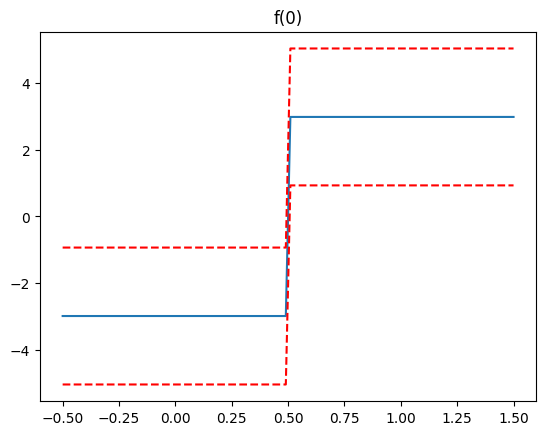

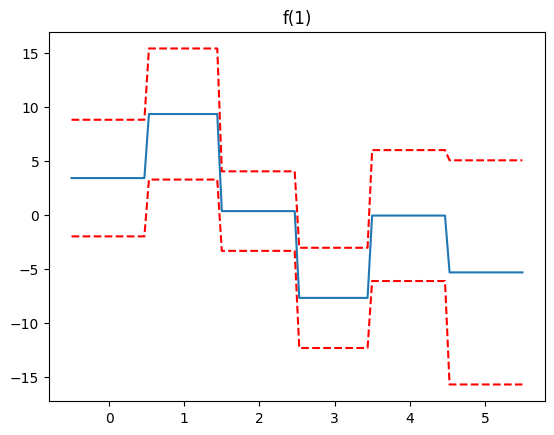

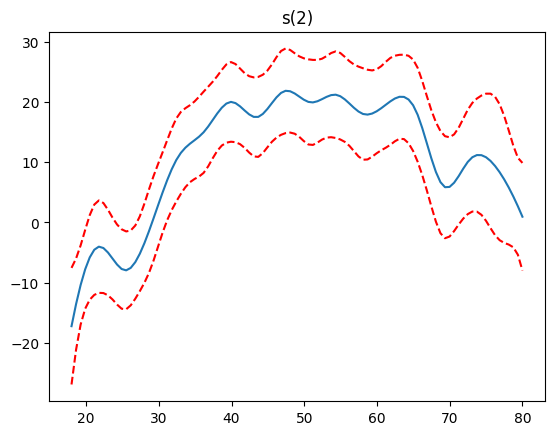

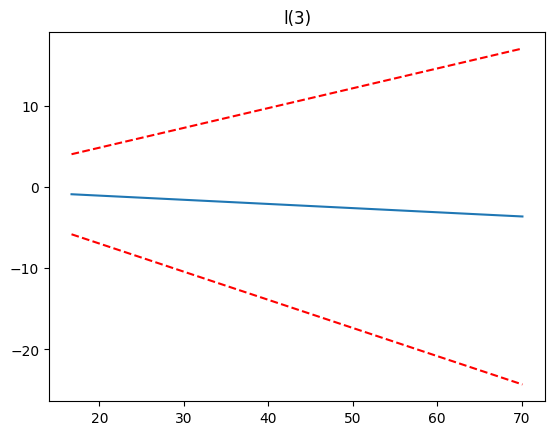

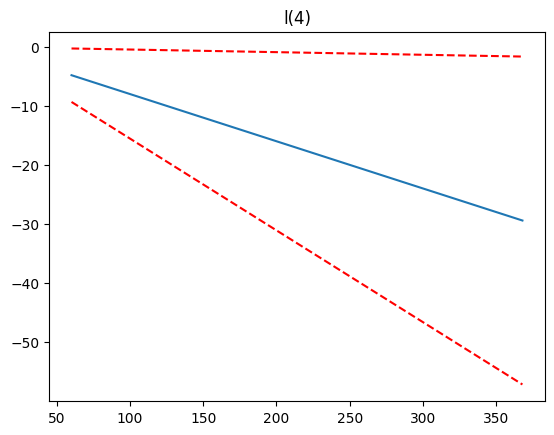

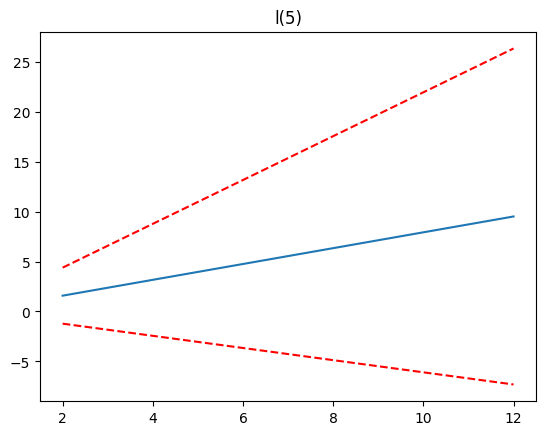

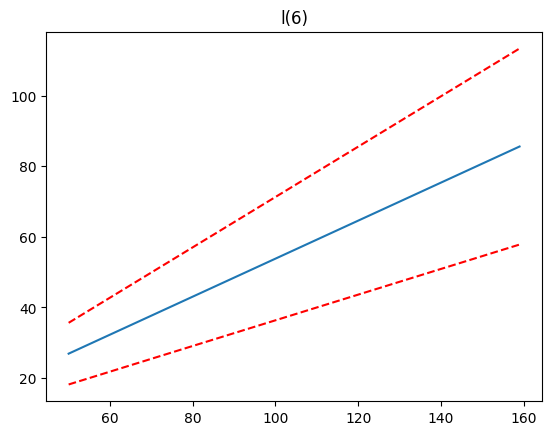

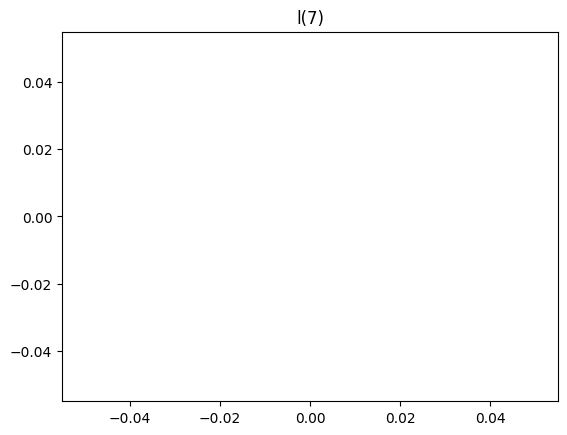

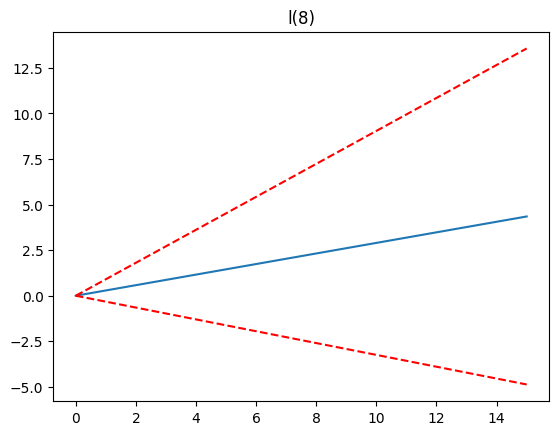

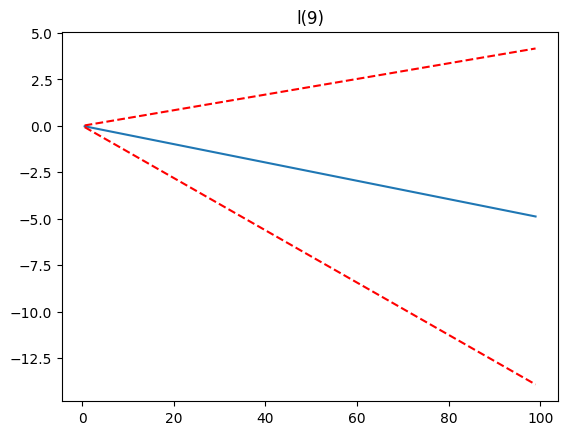

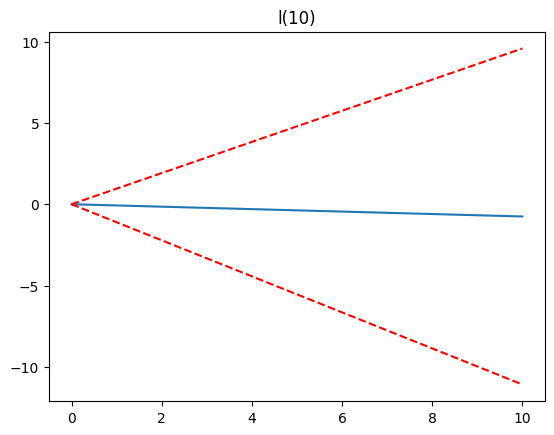

In [28]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()
